# Task A - Gender Classification

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [23]:
!pip install torch torchvision scikit-learn

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


## Set Paths and Hyperparameters

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths
TRAIN_DIR = "/content/drive/MyDrive/comsys-hackathon-5/Comys_Hackathon5/Task_A/train"
VAL_DIR = "/content/drive/MyDrive/comsys-hackathon-5/Comys_Hackathon5/Task_A/val"
MODEL_PATH = "/content/drive/MyDrive/comsys-hackathon-5/gender-classifier-model.pth"

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cpu


## Transforms and DataLoaders

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(VAL_DIR, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes  # ['female', 'male']
print("Classes:", class_names)

Classes: ['female', 'male']


## Define the Model

In [ ]:
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(DEVICE)

model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model architecture:\n")
print(model)

Model architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

##  Train the Model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_correct, val_loss = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_accuracy = 100 * val_correct / len(val_dataset)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 20)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")
    print(classification_report(y_true, y_pred, target_names=class_names))


Epoch 1/20
--------------------
Train Loss: 5.2252 | Val Loss: 2.3607
Train Acc: 96.63% | Val Acc: 95.26%
              precision    recall  f1-score   support

      female       0.91      0.90      0.90       105
        male       0.97      0.97      0.97       317

    accuracy                           0.95       422
   macro avg       0.94      0.93      0.94       422
weighted avg       0.95      0.95      0.95       422


Epoch 2/20
--------------------
Train Loss: 2.6157 | Val Loss: 2.1215
Train Acc: 98.65% | Val Acc: 93.13%
              precision    recall  f1-score   support

      female       0.92      0.79      0.85       105
        male       0.93      0.98      0.96       317

    accuracy                           0.93       422
   macro avg       0.93      0.88      0.90       422
weighted avg       0.93      0.93      0.93       422


Epoch 3/20
--------------------
Train Loss: 1.0630 | Val Loss: 2.0881
Train Acc: 99.53% | Val Acc: 95.02%
              precision  

## Save Model and Plot History

Model saved to /content/drive/MyDrive/comsys-hackathon-5/gender-classifier-model.pth


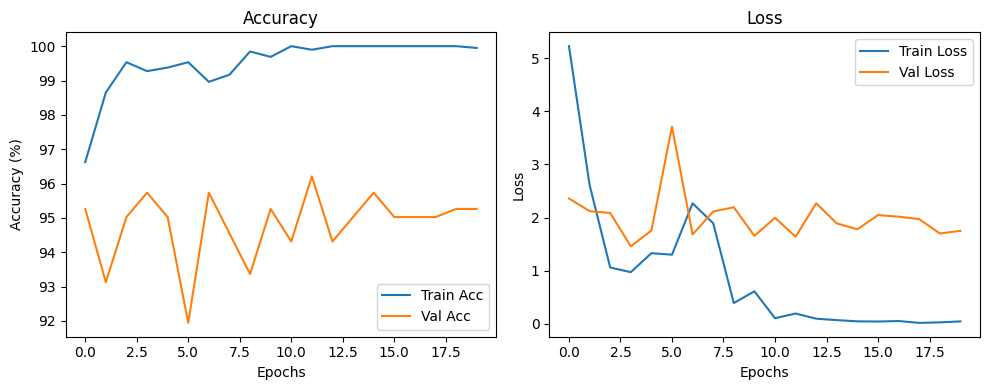

In [19]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("/content/training_curves.png")
plt.show()

## Plot Confusion Matrix and Classification Report

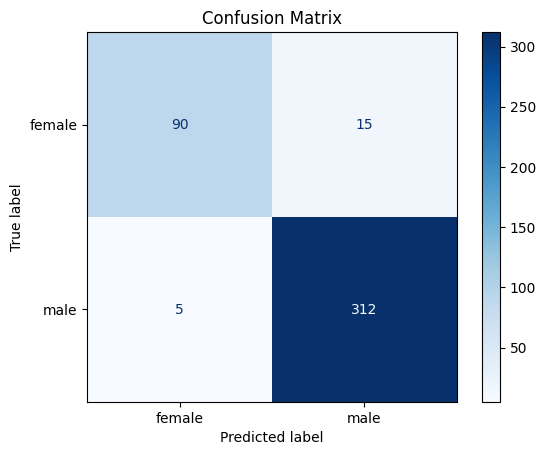

              precision    recall  f1-score   support

      female       0.95      0.86      0.90       105
        male       0.95      0.98      0.97       317

    accuracy                           0.95       422
   macro avg       0.95      0.92      0.93       422
weighted avg       0.95      0.95      0.95       422



In [24]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("/content/confusion_matrix.png")
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))


## Predict 100 Validation Samples and Visualize

In [25]:
import random

# Get 100 random samples from val set
sample_indices = random.sample(range(len(val_dataset)), 100)
samples = [val_dataset[i] for i in sample_indices]

rows, cols = 10, 10
fig = plt.figure(figsize=(30, 30))

for idx, (image, label) in enumerate(samples):
    img_tensor = image.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    decoded_label = class_names[label]
    decoded_pred = class_names[pred.item()]

    ax = fig.add_subplot(rows, cols, idx + 1)
    img_np = image.permute(1, 2, 0).numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # de-normalize
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.axis("off")
    ax.set_title(f"Actual: {decoded_label}\nPred: {decoded_pred}", fontsize=10)

plt.tight_layout()
plt.savefig("/content/sample_predictions.png")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Evaluation

In [26]:
def evaluate_model(model_path, test_dir):
    model = get_model()
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['val'])
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate on val set
evaluate_model(MODEL_PATH, VAL_DIR)



--- Evaluation Metrics ---
Accuracy : 0.9526
Precision: 0.9541
Recall   : 0.9842
F1 Score : 0.9689

--- Classification Report ---
              precision    recall  f1-score   support

      female       0.95      0.86      0.90       105
        male       0.95      0.98      0.97       317

    accuracy                           0.95       422
   macro avg       0.95      0.92      0.93       422
weighted avg       0.95      0.95      0.95       422



## Predict Custom Image

Saving ss.jpg to ss.jpg
Prediction: female


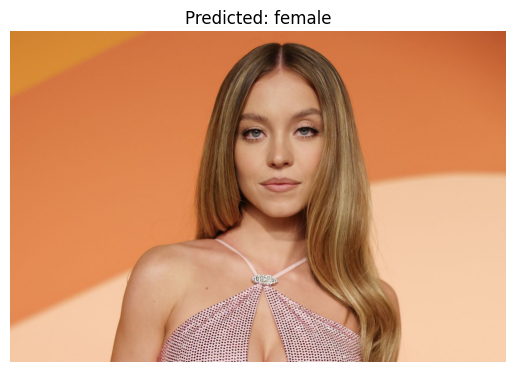

In [27]:
from google.colab import files
from torchvision import transforms
from PIL import Image

def predict_image(model_path=MODEL_PATH):
    model = get_model()
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    uploaded = files.upload()
    for fn in uploaded.keys():
        try:
            img = Image.open(fn).convert("RGB")
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ])
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                pred_label = class_names[pred.item()]

            print(f"Prediction: {pred_label}")
            plt.imshow(img)
            plt.title(f"Predicted: {pred_label}")
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"Error: {e}")

predict_image()